Plan:
1. get FEOBV HC vs Smokers difference map in MNI152 space
2. Parcellate the difference map using a DK atlas in MNI152 space
3. Select only left hemisphere of the parcellation

4. get gene expression scale033 data from Justine's paper
5. Convert expression data to DK atlas

6. Correlate FEOBV parcellation with gene expression using spin tests

In [2]:
# import numpy as np
import pandas as pd
import os
import nibabel as nb 
import numpy as np

import warnings 
warnings.filterwarnings("ignore", category=DeprecationWarning)
warnings.filterwarnings("ignore", category=FutureWarning)

from neuromaps.images import load_data, load_gifti, annot_to_gifti, relabel_gifti, construct_shape_gii
from neuromaps.datasets import fetch_annotation
from neuromaps.resampling import resample_images
from neuromaps.nulls import alexander_bloch, burt2020
from neuromaps.parcellate import Parcellater
from scipy.stats import pearsonr
from neuromaps import transforms 
from neuromaps.stats import compare_images
from neuromaps.nulls import hungarian

from surfplot import Plot
from neuromaps.datasets import fetch_fsaverage


In [3]:
# define working dir 
base_path = os.path.dirname(os.getcwd())

# create a object that will parcellate data into dk atlas
dk_mni = os.path.join(base_path, 'parcellations', 'atlas-desikankilliany_space-MNI_res-1mm.nii.gz')
parcellater_mni = Parcellater(dk_mni , 'MNI152')

In [4]:
# get FEOBV data 
smoking_pctdiff_file = os.path.join(base_path, 'data', 'smoking_pctdiff.nii.gz')

In [5]:
# parcellate FEOBV data 
smoking_parc = parcellater_mni.fit_transform(smoking_pctdiff_file, space='MNI152', ignore_background_data=True)

In [6]:
# read labels, add diff to dataframe and take only left cortex parcels 
labels = pd.read_csv(os.path.join(base_path, 'parcellations','atlas-desikankilliany.csv') )
labels['pctdiff'] = smoking_parc[0]
lh_labels = labels[(labels['hemisphere'] == 'L') & (labels['structure'] == 'cortex')]
lh_labels

,id,label,hemisphere,structure,pctdiff
0,1,bankssts,L,cortex,5.062069
1,2,caudalanteriorcingulate,L,cortex,1.545742
2,3,caudalmiddlefrontal,L,cortex,5.585381
3,4,cuneus,L,cortex,7.520157
4,5,entorhinal,L,cortex,-0.441212
5,6,fusiform,L,cortex,4.713133
6,7,inferiorparietal,L,cortex,8.578709
7,8,inferiortemporal,L,cortex,5.533962
8,9,isthmuscingulate,L,cortex,4.495432
9,10,lateraloccipital,L,cortex,5.751257


In [7]:
# do some stuff for plotting  
def get_labels(annot):
    aparc = os.path.join(os.environ['SUBJECTS_DIR'], 'fsaverage', 'label', annot)
    labels, ctab , names = nb.freesurfer.read_annot(aparc)
    labels = [i-1 if i>3 else i for i in labels] # good lord
    return(labels)

lh_parcelindex = get_labels('lh.aparc.annot')    
#rh_labels = get_labels('rh.aparc.annot')  
#lh_dk_parcelnames 


lh_labels.index = range(1, len(lh_labels) + 1)
pctdiff_dict= lh_labels['pctdiff'].to_dict()
#pctdiff_dict.update([(0,0), (-1,0)])
  #partial_r_dict.update([(0,0), (-1,0)])
pctdiff_dict
map = np.array([pctdiff_dict.get(index) for index in lh_parcelindex])

In [8]:
map.shape 

(163842,)

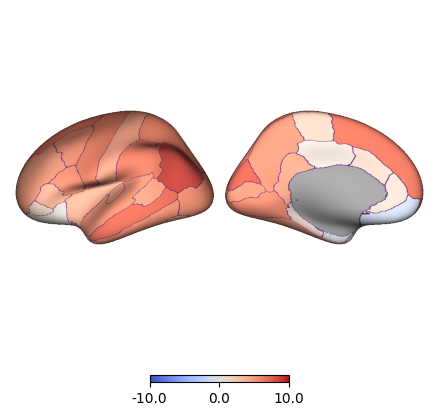

In [9]:
surface = fetch_fsaverage(density='164k')
lh, _ = surface['inflated']
dk = {'left': np.array(lh_parcelindex)}

# plot
p = Plot(lh, None, views=['lateral','medial'], zoom=1.2)
p.add_layer(map, cmap='coolwarm',color_range=(-10,10), cbar=True,zero_transparent=True  )
p.add_layer(dk, as_outline=True, cbar=False)
pic = p.build()

In [10]:
autorad = np.load('/Users/laurituominen/Downloads/hansen_gene-receptor/results/autorad_data.npy')

In [12]:
autorad.shape

(33, 15)